<a href="https://colab.research.google.com/github/RAVIAPTISWETHA/MENDELEY/blob/main/M_DLA_Heart_Diseases_using_ECG_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing Libraries**


In [72]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Loading**

In [74]:
dir_mendeley = '/content/drive/My Drive/Colab Notebooks/ECGM'

In [75]:
def dataloader(dir ):
    folders = os.listdir(dir)
    file_path = []
    labels = []
    sub_folders =[]
    for folder in folders:
        sub_folder = os.path.join(dir, folder)
        sub_list = os.listdir(sub_folder)
        for file in sub_list:
            f_path = os.path.join(sub_folder, file)
            file_path.append(f_path)
            labels.append(folder)
    return file_path, labels
train_file_path, train_labels = dataloader(dir_mendeley)
print(len(train_file_path))
mendeley_path, mendeley_labels = dataloader(dir_mendeley )
df = pd.DataFrame({'file_path': mendeley_path, "labels": mendeley_labels})
df.labels.value_counts()

707


,count
labels,
Normal Person,295
Abnormal heartbeat,241
History of MI,171


# **Class Distribution**

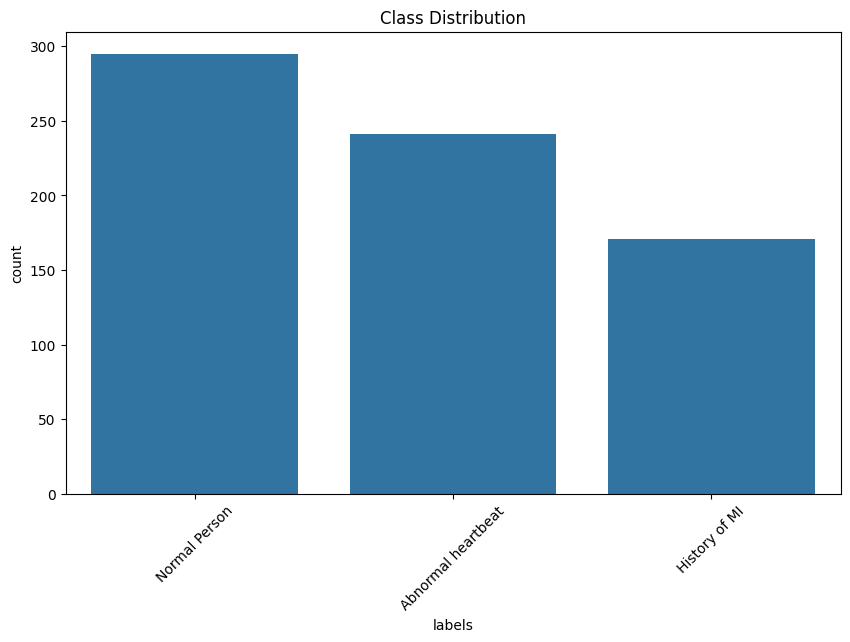

In [76]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

In [77]:
def preprocess_image(image_path, target_size=(224,224)):
    """
    Preprocess single image with enhancement techniques

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output image size

    Returns:
        np.ndarray: Preprocessed image
    """
    try:
        # Read image with error handling
        image = cv2.imread(image_path)

        # Check if image is loaded successfully
        if image is None:
            print(f"Warning: Unable to read image {image_path}")
            return None

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize with aspect ratio preservation
        h, w = image.shape[:2]
        aspect_ratio = w / h

        # Resize maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(new_w / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(new_h * aspect_ratio)

        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Create blank canvas
        canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

        # Calculate positioning to center the image
        y_start = (target_size[1] - new_h) // 2
        x_start = (target_size[0] - new_w) // 2

        # Place resized image on canvas
        canvas[y_start:y_start+new_h, x_start:x_start+new_w] = resized

        # Convert to float and normalize
        normalized = canvas.astype(np.float32) / 255.0

        return normalized

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [78]:
def prepare_dataset(file_dir, test_size=0.2, random_state=42):
    """
    Prepare and preprocess the entire dataset

    Args:
        file_dir (str): Path to the dataset directory
        test_size (float): Proportion of dataset for testing
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: Preprocessed and split dataset
    """
    # Load dataset using the defined dataloader function
    filepaths, labels = dataloader(file_dir)
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})

    # Preprocess images with error handling
    processed_images = []
    processed_labels = []

    for path, label in zip(df['filepath'], df['label']):
        img = preprocess_image(path)
        if img is not None:
            processed_images.append(img)
            processed_labels.append(label)

    # Convert to numpy array
    X = np.array(processed_images)

    # Encode labels
    label_encoder = {label: idx for idx, label in enumerate(sorted(set(processed_labels)))}
    y = np.array([label_encoder[label] for label in processed_labels])

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, label_encoder

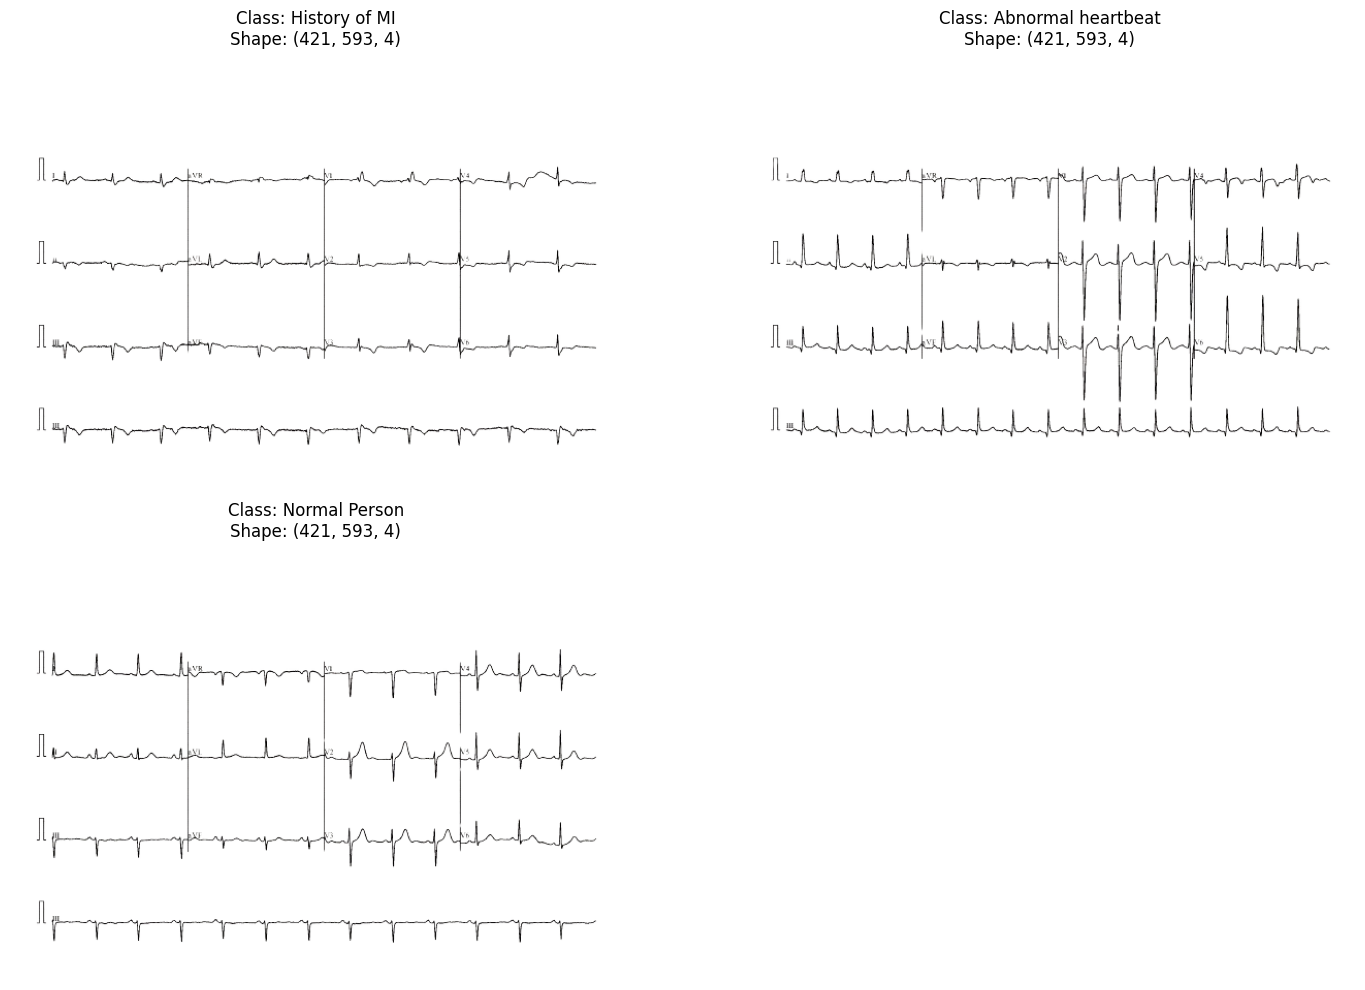

In [79]:
import matplotlib.image as mpimg

# Display sample images from each class
plt.figure(figsize=(15,10))
for i, label in enumerate(df['labels'].unique()):
    sample_path = df[df['labels']==label]['file_path'].iloc[0]
    img = mpimg.imread(sample_path)

    plt.subplot(2,2,i+1)
    plt.imshow(img, cmap='gray' if len(img.shape)==2 else None)
    plt.title(f"Class: {label}\nShape: {img.shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [80]:
# Prepare dataset
X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(dir_mendeley)

# Print shapes and details
print("Original training data shape:", X_train.shape)
print("Label Encoding:", label_encoder)

Original training data shape: (565, 224, 224, 3)
Label Encoding: {'Abnormal heartbeat': 0, 'History of MI': 1, 'Normal Person': 2}


# CNN

In [81]:
def create_cnn_model(hp):
    model = models.Sequential()

    # First convolutional layer with correct input shape
    model.add(layers.Conv2D(
        hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        (3, 3),
        activation='relu',
        input_shape=(224, 224, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(layers.Conv2D(
        hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(layers.Conv2D(
        hp.Int('conv_3_filter', min_value=128, max_value=512, step=128),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth convolutional layer to reduce spatial dimensions further
    model.add(layers.Conv2D(
        hp.Int('conv_4_filter', min_value=256, max_value=1024, step=256),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # First dense layer
    model.add(layers.Dense(
        hp.Int('dense_1_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(
        hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    ))

    # Second dense layer
    model.add(layers.Dense(
        hp.Int('dense_2_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(
        hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    ))

    # Output layer
    model.add(layers.Dense(len(label_encoder), activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [82]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from kerastuner.tuners import RandomSearch

def train_and_evaluate_single_model(model_func, model_name, X_train, X_test, y_train, y_test):
    """
    Hyperparameter tune, train, and evaluate a single model
    """
    print(f"\n{'='*50}")
    print(f"Training and Evaluating {model_name}")
    print(f"{'='*50}")

    # Prepare data
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # Hyperparameter Tuning
    print("\nPerforming Hyperparameter Tuning...")
    tuner = RandomSearch(
        model_func,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=1,
        directory=f'hp_tuning_{model_name}',
        project_name=model_name
    )

    tuner.search(
        X_train, y_train_cat,
        epochs=20,
        validation_split=0.2,
        verbose=1
    )

    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    # Get best model
    best_model = tuner.get_best_models(1)[0]

    # Print model summary
    print("\nModel Architecture:")
    best_model.summary()

    # Train the model with best hyperparameters
    print("\nTraining Model with Best Hyperparameters...")
    history = best_model.fit(
        X_train, y_train_cat,
        epochs=40,
        validation_split=0.2,
        verbose=1
    )

    # Model Evaluation
    print("\nEvaluating Model Performance...")
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    roc_auc = roc_auc_score(y_test_cat, y_pred, multi_class='ovr', average='weighted')

    # Print evaluation metrics
    print("\nModel Performance Metrics:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.close()

    return best_model, history



Processing Custom CNN Model...

Training and Evaluating Custom_CNN

Performing Hyperparameter Tuning...
Reloading Tuner from hp_tuning_Custom_CNN/Custom_CNN/tuner0.json

Best Hyperparameters:
conv_1_filter: 96
conv_2_filter: 64
conv_3_filter: 384
conv_4_filter: 1024
dense_1_units: 256
dropout_1: 0.2
dense_2_units: 32
dropout_2: 0.2
learning_rate: 1e-05


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 384)    │       221,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 1024)   │     3,539,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    37,748,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,583,171 (158.63 MB)

 Trainable params: 41,580,035 (158.62 MB)

 Non-trainable params: 3,136 (12.25 KB)


Training Model with Best Hyperparameters...
Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 590ms/step - accuracy: 0.9145 - loss: 0.2525 - val_accuracy: 0.2035 - val_loss: 2.3753
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.8590 - loss: 0.3712 - val_accuracy: 0.2035 - val_loss: 2.4460
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9195 - loss: 0.2206 - val_accuracy: 0.2035 - val_loss: 2.5379
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9202 - loss: 0.1864 - val_accuracy: 0.2035 - val_loss: 2.5987
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9335 - loss: 0.1793 - val_accuracy: 0.2035 - val_loss: 2.7364
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9602 - loss: 0.1406 - val_accuracy: 0.2035 - val_loss: 2.7431
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9808 - loss: 0.1037 - val_accuracy: 0.2035 - val_loss: 2.6957
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accu

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step

Model Performance Metrics:
Test Accuracy: 0.8732
F1 Score: 0.8695
ROC AUC Score: 0.9851


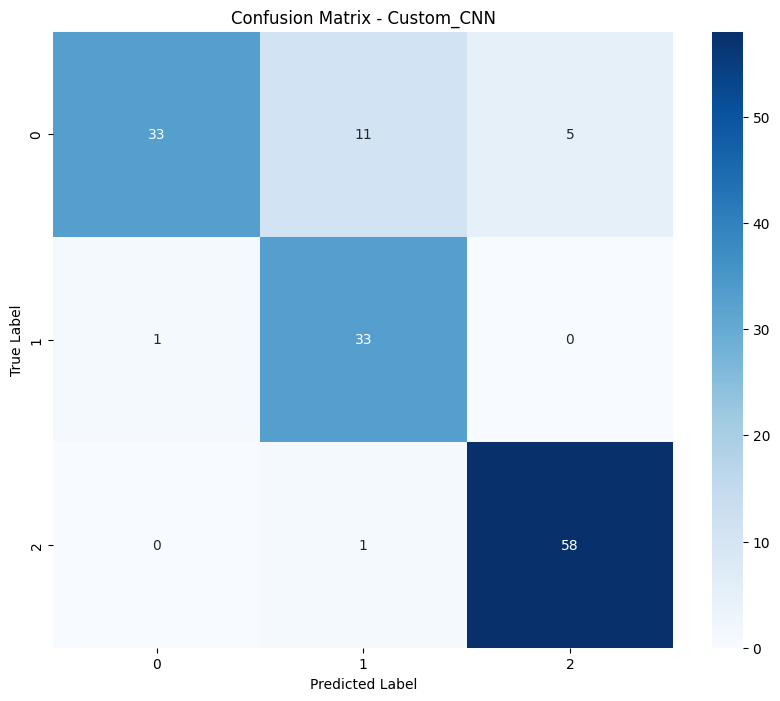

In [83]:
# 1. Train and Evaluate Custom CNN
print("\nProcessing Custom CNN Model...")
cnn_model, cnn_history = train_and_evaluate_single_model(
    create_cnn_model,
    "Custom_CNN",
    X_train, X_test,
    y_train, y_test
)